## Problem Statement

Build a model to recognize emotion from speech using Ensemble learning 

**TESS Dataset**

The first dataset chosen for this mini-project is the [TESS](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF) (Toronto emotional speech set) dataset. It contains 2880 files.  A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses and the sets were recorded in seven different emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Both actresses spoke English as their first language, were university educated, and had musical training. Audiometric testing indicated that both actresses had thresholds within the normal range.

**Ravdess Dataset**

The second dataset chosen for this mini-project is [Ravdess](https://zenodo.org/record/1188976#.YLczy4XivIU) (The Ryerson Audio-Visual Database of Emotional Speech and Song). This dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

    - Audio-only - 03
    - Speech - 01
    - Fearful - 06
    - Normal intensity - 01
    - Statement "dogs" - 02
    - 1st Repetition - 01
    - 12th Actor - 12 Female, as the actor ID number is even.

### Import Neccesary Packages

In [ ]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import warnings
warnings.filterwarnings('ignore')
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier

In [ ]:
# YOUR CODE HERE
ravdess_file = glob.glob('ravdess/Actor_*/*.wav')

In [ ]:
tess_file = glob.glob('Tess/*AF_*/*.wav')

In [ ]:
rav_tess_file = ravdess_file + tess_file

#### Play the sample audio

In [ ]:
# YOUR CODE HERE
ravdess_file[5]

'ravdess/Actor_10/03-01-03-01-01-02-10_happy.wav'

In [ ]:
ipd.Audio('ravdess/Actor_10/03-01-03-01-01-02-10_happy.wav')

In [ ]:
tess_file[9]

'Tess/YAF_surprised/YAF_take_surprised.wav'

In [ ]:
ipd.Audio('Tess/YAF_surprised/YAF_take_surprised.wav')

***RAVDESS***

In [ ]:
# YOUR CODE HERE
# Loading RAVDESS dataset in a dataframe with emotions
# There are male and female actors in this dataset. Lets distinguish those first.

def rav_gender(g):
    if int(g[0:2]) % 2 == 0:
        return 'female'
    else:
        return 'male'

In [ ]:
# mapping observed emotions from dataset
rev_mapping = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust', '08':'surprised'}

In [ ]:
rav_emotions = []
rav_audio_path = []

for file in ravdess_file: #glob.glob('ravdess/Actor_*/*.wav'):
    file_name=os.path.basename(file)
    if (file_name.split('-')[2] in rev_mapping):
        #rev_map = rev_mapping[file_name.split('-')[2]] + '_' + rav_gender(file_name.split('-')[-1])
        rev_map = rev_mapping[file_name.split('-')[2]]
        rav_emotions.append(rev_map)
        rav_audio_path.append(file)

In [ ]:
df_rav_path = pd.DataFrame(rav_audio_path, columns=['Path'])
df_rav_emotions = pd.DataFrame(rav_emotions, columns = ['Emotions'])

In [ ]:
df_ravdess = pd.concat([df_rav_emotions, df_rav_path], axis=1)

In [ ]:
rav_male_emotions, rav_female_emotions = [], []
rav_male_audio_path, rav_female_audio_path = [], []

for file in ravdess_file: #glob.glob('ravdess/Actor_*/*.wav'):
    file_name=os.path.basename(file)
    if (file_name.split('-')[2] in rev_mapping):
        rev_map = rev_mapping[file_name.split('-')[2]]
        if rav_gender(file_name.split('-')[-1]) == 'female':
            rav_female_emotions.append(rev_map)
            rav_female_audio_path.append(file)
        else:
            rav_male_emotions.append(rev_map)
            rav_male_audio_path.append(file)

In [ ]:
df_rav_female_path = pd.DataFrame(rav_female_audio_path, columns=['Path'])
df_rav_female_emotions = pd.DataFrame(rav_female_emotions, columns = ['Emotions'])

df_rav_male_path = pd.DataFrame(rav_male_audio_path, columns=['Path'])
df_rav_male_emotions = pd.DataFrame(rav_male_emotions, columns = ['Emotions'])

In [ ]:
df_ravdess_female = pd.concat([df_rav_female_emotions, df_rav_female_path], axis=1)

df_ravdess_male = pd.concat([df_rav_male_emotions, df_rav_male_path], axis=1)

In [ ]:
df_ravdess.nunique()

Emotions       7
Path        1168
dtype: int64

In [ ]:
df_ravdess.Emotions.value_counts()

sad          183
surprised    182
fear         182
disgust      180
angry        179
happy        174
neutral       88
Name: Emotions, dtype: int64

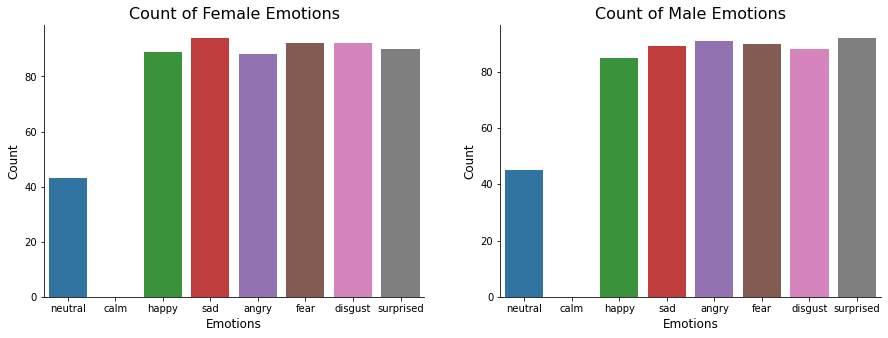

In [ ]:
order = ['neutral','calm','happy','sad','angry','fear','disgust','surprised']

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.title('Count of Female Emotions', size=16)
sns.countplot(df_ravdess_female.Emotions, order=order)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

fig.add_subplot(122)
plt.title('Count of Male Emotions', size=16)
sns.countplot(df_ravdess_male.Emotions, order=order)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

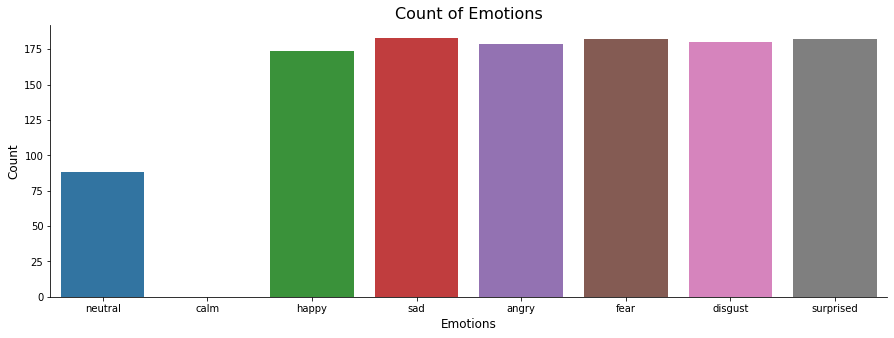

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(df_ravdess.Emotions, order=order)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

***TESS***

In [ ]:
tess_emotions=['angry','calm','disgust','fear','happy', 'neutral', 'surprised', 'sad']

In [ ]:
tess_emt, tess_audio_path =[],[]

for file in tess_file: #glob.glob('Tess/*AF_*/*.wav'):
    file_name=os.path.basename(file)
    emotions=file_name.split("_")[2][:-4] #split and remove .wav
    tess_emt.append(emotions)
    tess_audio_path.append(file)
    

In [ ]:
set(tess_emt)

{'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised'}

In [ ]:
df_tess_path = pd.DataFrame(tess_audio_path, columns=['Path'])
df_tess_emotions = pd.DataFrame(tess_emt, columns = ['Emotions'])

In [ ]:
df_tess = pd.concat([df_tess_emotions, df_tess_path], axis=1)

In [ ]:
df_tess.nunique()

Emotions       7
Path        2679
dtype: int64

In [ ]:
df_tess.Emotions.value_counts()

disgust      391
surprised    387
happy        383
angry        382
fear         379
sad          379
neutral      378
Name: Emotions, dtype: int64

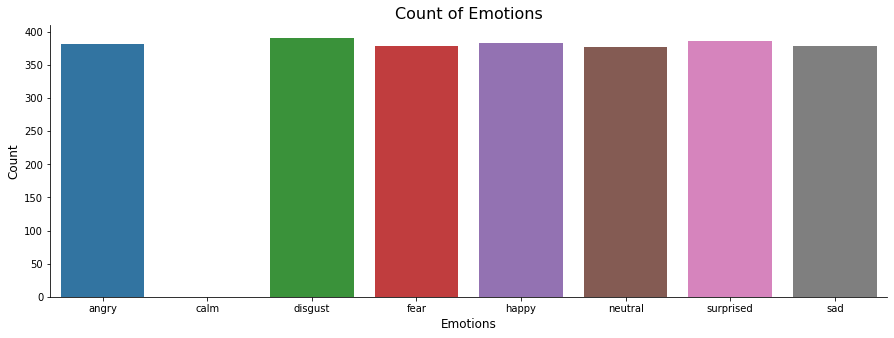

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(df_tess.Emotions, order=tess_emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

#### Visualize sample audio signal using librosa

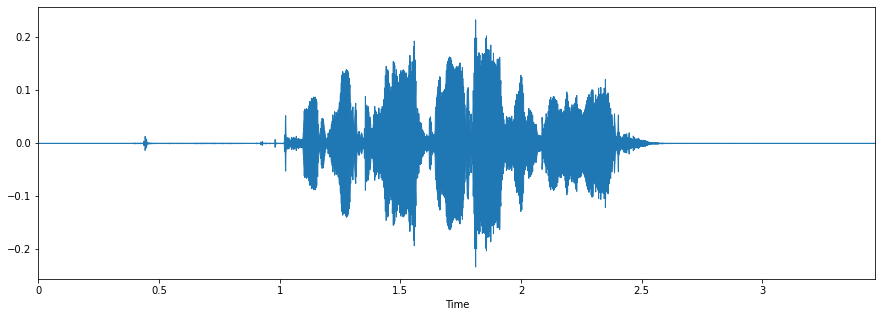

In [ ]:
# YOUR CODE HERE
# Method 1
# Display waveplot for Ravdess Audio
rav_sample_audio_path = 'ravdess/Actor_10/03-01-03-01-01-02-10_happy.wav'
data, sampling_rate = librosa.load(rav_sample_audio_path)
plt.figure(figsize = (15,5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

In [ ]:
# Alternate Method by creating a definition which can be called multiple times
def create_waveplot(data, sampling_rate):
    plt.figure(figsize = (15,5))
    plt.title('Waveplot of Audio')
    librosa.display.waveplot(data, sr=sampling_rate)
    plt.show()

***RAVDESS Audio Signal Sample***

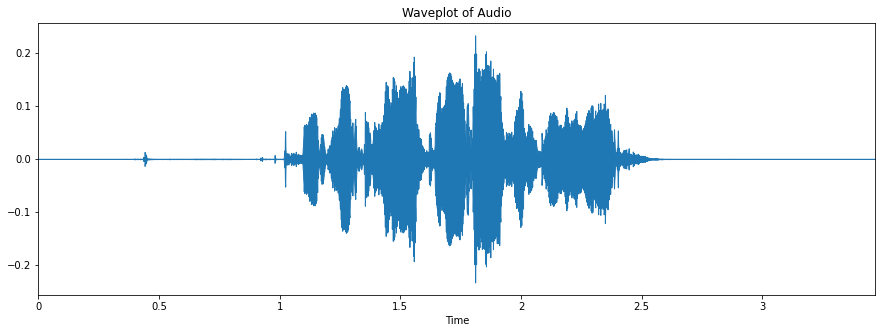

In [ ]:
rav_sample_audio_path = 'ravdess/Actor_10/03-01-03-01-01-02-10_happy.wav'
data, sampling_rate = librosa.load(rav_sample_audio_path)
create_waveplot(data, sampling_rate)
ipd.Audio(rav_sample_audio_path)

***TESS Audio Signal Sample***

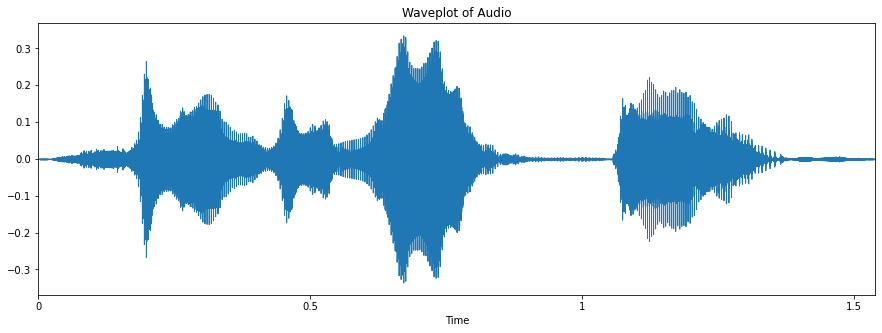

In [ ]:
tess_sample_audio_path = 'Tess/OAF_angry/OAF_back_angry.wav'
data, sampling_rate = librosa.load(tess_sample_audio_path)
create_waveplot(data, sampling_rate)
ipd.Audio(tess_sample_audio_path)

In [ ]:
# YOUR CODE HERE
def extract_feature(file_name):
    # load audio
    X, sample_rate = librosa.load(file_name)
    # apply stft()
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    # compute mfcc
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    # combine the features
    result=np.hstack((result, mfccs))
    # compute chroma features and combine
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    # compute melspectrogram and combine
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

In [ ]:
rav_sample_feature = extract_feature(ravdess_file[10])#,mfcc=True, chroma=True, mel=True)
rav_sample_feature.shape

(180,)

In [ ]:
type(rav_sample_feature)

numpy.ndarray

In [ ]:
tess_sample_feature = extract_feature(tess_file[10])#,mfcc=True, chroma=True, mel=True)
tess_sample_feature.shape

(180,)

In [ ]:
type(tess_sample_feature)

numpy.ndarray

#### Create a dictionary or a function to encode the emotions

In [ ]:
# YOUR CODE HERE
#{'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust', '08':'surprised'}
emotions_dict = {"neutral":1, "calm":2, "happy":3, "sad":4, "angry":5, "fear":6, "disgust":7, "surprised":8}
emotions_dict

{'angry': 5,
 'calm': 2,
 'disgust': 7,
 'fear': 6,
 'happy': 3,
 'neutral': 1,
 'sad': 4,
 'surprised': 8}

In [ ]:
emotions_dict["neutral"]

1

#### TESS data feature extraction

In [ ]:
# YOUR CODE HERE
# Declare list to append features and labels
tess_features, tess_labels = [], []

for file in tess_file:
  tess_features.append(extract_feature(file))
  # extracting label
  arr = file.split("/")
  emt=arr[2].split('_')[2][:-4]
  tess_labels.append(emotions_dict[emt.lower()])

In [ ]:
set(tess_labels)

{1, 3, 4, 5, 6, 7, 8}

#### Ravdess data feature extraction

In [ ]:
# YOUR CODE HERE
rav_features, rav_labels = [], []

for file in ravdess_file:
  rav_features.append(extract_feature(file))
  # extracting label
  emt=file.split("-")[2][-1]
  #rav_labels.append(emotions_dict[emt])
  rav_labels.append(emt)

In [ ]:
rav_features

In [ ]:
set(rav_labels)

{'1', '3', '4', '5', '6', '7', '8'}

In [ ]:
# YOUR CODE HERE
#RAVDESS
df_rav_features = pd.DataFrame(rav_features)
df_rav_labels = pd.DataFrame(rav_labels)

In [ ]:
#TESS
df_tess_features = pd.DataFrame(tess_features)
df_tess_labels = pd.DataFrame(tess_labels)

In [ ]:
df_ravFE = pd.concat([df_rav_features, df_rav_labels], axis=1)

In [ ]:
df_tessFE = pd.concat([df_rav_features, df_rav_labels], axis=1)

In [ ]:
df_tessFE

In [ ]:
df_ravFE

In [ ]:
# Storing ravdess FE in .csv
df_ravFE.to_csv("Ravdess_Features_labels.csv")

***Adding RAVDESS & TESS Dataframes***

In [ ]:
df_data = pd.concat([df_ravdess, df_tess], axis = 0)
df_data.to_csv("RAV_TESS_data.csv",index=False)
df_data.Emotions.value_counts()

disgust      571
surprised    569
sad          562
fear         561
angry        561
happy        557
neutral      466
Name: Emotions, dtype: int64

In [ ]:
df_data

,Emotions,Path
0,surprised,ravdess/Actor_10/03-01-08-01-02-02-10_surprise...
1,sad,ravdess/Actor_10/03-01-04-01-01-02-10_sad.wav
2,surprised,ravdess/Actor_10/03-01-08-02-01-02-10_surprise...
3,happy,ravdess/Actor_10/03-01-03-01-02-02-10_happy.wav
4,fear,ravdess/Actor_10/03-01-06-01-02-02-10_fear.wav
...,...,...
2674,angry,Tess/YAF_angry/YAF_wag_angry.wav
2675,angry,Tess/YAF_angry/YAF_soap_angry.wav
2676,angry,Tess/YAF_angry/YAF_food_angry.wav
2677,angry,Tess/YAF_angry/YAF_wheat_angry.wav


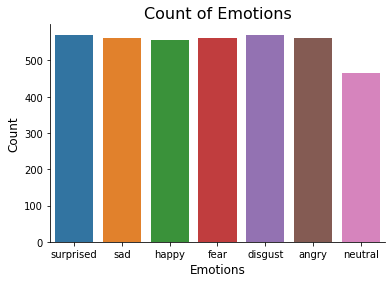

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(df_data.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
features, labels = [], []

for wv_file in rav_tess_file:
    features.append(extract_feature(wv_file))
    # extracting label
    arr = wv_file.split("/")
    ds = arr[0]
    if ds == "Tess":
       #emotion = arr[2].split('_')[2][:-4]
       emotion = arr[1].split('_')[1]
    else:
       # emotion = arr[2].split('_')[-1][:-4]
       emotion = arr[-1].split('_')[1].split('.')[0]
    labels.append(emotions_dict[emotion.lower()])

In [ ]:
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels)

In [ ]:
df_labels.value_counts()

7    571
8    569
4    562
5    561
6    561
3    557
1    466
dtype: int64

In [ ]:
df_dataFE = pd.concat([df_features, df_labels], axis=1)

In [ ]:
df_dataFE.shape

(3847, 181)

#### Split the data into train and test

In [ ]:
# YOUR CODE HERE
X = df_dataFE.iloc[: ,:-1]

In [ ]:
y = df_dataFE.iloc[: ,-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state= 123)

In [ ]:
# YOUR CODE HERE
from sklearn.neighbors import KNeighborsClassifier as KNN
log_clf = LogisticRegression(class_weight='balanced', max_iter=600, random_state=123)
knn_clf = KNN(n_neighbors=10)
dt_clf = tree.DecisionTreeClassifier(max_depth = 20, random_state=123)

rf_clf = RandomForestClassifier(n_estimators=600,           # number of trees in the forest
                                #max_leaf_nodes=60,          # grow trees with max_leaf_nodes, selected by 
                                                            # relative reduction in impurity. 
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 123
                                )


for clf in (log_clf, knn_clf, dt_clf, rf_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.806060606060606
KNeighborsClassifier 0.8069264069264069
DecisionTreeClassifier 0.7653679653679654
RandomForestClassifier 0.8735930735930736


#### Apply the voting classifier

In [ ]:
# YOUR CODE HERE
classifiers = [('lr', log_clf), ('knn', knn_clf), ('dt', dt_clf), ('rf', rf_clf)]

voting_clf = VotingClassifier(estimators= classifiers, voting='hard')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(voting_clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.8614718614718615
